In [3]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
import eli5
import sklearn

from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, TargetEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report

In [4]:
train = pd.read_csv('data/train_clean.csv', index_col = 0)
X_test = pd.read_csv('data/test_clean.csv', index_col = 0)
submission = pd.read_csv('data/sample_submission.csv')

feature = ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'family_size', 'age', 'work_year', 'use_month', 'income_total']
target = ['credit']

X_train = train[feature]
y_train = train[target]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[feature],train[target], test_size = 0.2, train_size = 0.8)

### Baseline Model

In [5]:
total = len(y_train)
zero = float((y_train == 0).sum() / total)
one = float((y_train == 1).sum() / total)
two = float((y_train == 2).sum() / total)

baseline = [zero, one, two]
baseline_proba = [baseline] * total
baseline_pred = [2] * total

In [46]:
def confusion_matrix(y_pred, y_real):
    tp, tn, fp, fn = -1, -1, -1, -1

    tp = len((y_pred == 1) & (y_real == 1))
    # YOUR CODE HERE
    tn = sum((y_pred == 0) & (y_real == 0))
    fp = sum((y_pred == 1) & (y_real == 0))
    fn = sum((y_pred == 0) & (y_real == 1))

    # YOUR CODE ENDS HERE

    return tp, tn, fp, fn

def calculate_performances(y_pred, y_real):
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0

    tp, tn, fp, fn = confusion_matrix(y_pred, y_real)
    # YOUR CODE HERE
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    
    # YOUR CODE ENDS HERE

    return accuracy, precision, recall, f1
    
y_pred = np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1])
y_real = np.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
# calculate_performances(y_pred, y_real)


In [47]:
df = pd.DataFrame(baseline_pred)
calculate_performances(np.array(baseline_pred), np.array(y_train))
# sum((np.array(df) == 0) & (np.array(y_train) == 0))



(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]))

In [7]:
print('Baseline Model')
print('Accuracy : ', accuracy_score(y_train, baseline_pred))
print('Log Loss : ', log_loss(y_train, baseline_proba))
print(classification_report(y_train, baseline_pred))

Baseline Model
Accuracy :  0.641261199954633
Log Loss :  0.8825464036975457
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3222
         1.0       0.00      0.00      0.00      6267
         2.0       0.64      1.00      0.78     16962

    accuracy                           0.64     26451
   macro avg       0.21      0.33      0.26     26451
weighted avg       0.41      0.64      0.50     26451



/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prozapple/.pyenv/versions/3.10.3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

## Modeling

### XGB Classifier

In [5]:
xgb_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', XGBClassifier(n_estimators=200, 
                          random_state=42,
                          n_jobs=-1,
                          max_depth=7,
                          learning_rate=0.2))], verbose = 1)

xgb_model.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  17.6s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['income_type',
                                                       'edu_type',
                                                       'family_type',
                                                       'house_type',
                                                       'occyp_type'],
                                                 mapping=[{'col': 'income_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Commercial associate    1
Working                 2
State servant           3
Pensioner               4
Student                 5
NaN                    -2
dtype: int64},
                                                          {'col': 'edu_type',
                                                           'data_type': dtype('O'),
                                                           'mapping': Highe...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=7, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=1)

#### Early Stopping

In [ ]:
X_train_transformed = xgb_model.named_steps['preprocessing'].transform(X_train)
X_val_transformed = xgb_model.named_steps['preprocessing'].transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

xgb_model.named_steps['xgb'].fit(X_train_transformed, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

#### Hyperparameter Tunning

In [ ]:
%%time
params = {'classifier__max_depth':[5,6,7,8,9,10,15], 
          'classifier__min_child_weight':[5,7,10,15], 
          'classifier__colsample_bytree':[0.5,0.75],
          'classifier__learning_rate' : uniform(0,0.2)}

randcv = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter = 10,
                            cv=5,
                            scoring = 'neg_log_loss',
                            verbose = 100,
                            random_state = 42)

randcv.fit(X_train, y_train)

#튜닝된 파라미터 출력
print(randcv.best_params_)


In [48]:
xgb_tuned = Pipeline([
    ('preprocessing', make_pipeline(TargetEncoder(), SimpleImputer())),
    ('classifier', XGBClassifier(n_estimators=200, 
                          random_state=42,
                          n_jobs=-1,
                          max_depth=10,
                          colsample_bytree = 0.5,
                          min_child_weight = 5,
                          learning_rate=0.06084844859190755))], verbose = 10)

xgb_tuned.fit(X_train, y_train)


[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.5s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  50.1s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('targetencoder',
                                  TargetEncoder(cols=['income_type', 'edu_type',
                                                      'family_type',
                                                      'house_type',
                                                      'occyp_type'])),
                                 ('simpleimputer', SimpleImputer())])),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.5, early_stopping_rounds=No...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.06084844859190755, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=10, max_leaves=0, min_child_weight=5,
                               missing=nan, monotone_constraints='()',
                               n_estimators=200, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))],
         verbose=10)

In [51]:
model_score(xgb_tuned)
print(classification_report(xgb_tuned.predict(X_train), y_train))

Model Score
Train Set Accuracy Score :  0.7497259082832407
Train Set Log Loss Score :  0.5916905193875351
              precision    recall  f1-score   support

           0       0.19      0.92      0.32       676
           1       0.38      0.87      0.53      2717
           2       0.99      0.73      0.84     23058

    accuracy                           0.75     26451
   macro avg       0.52      0.84      0.56     26451
weighted avg       0.91      0.75      0.80     26451



### RandomForestClassifier

In [ ]:
rfc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', RandomForestClassifier(n_estimators=200, 
                                   random_state=2,
                                   n_jobs=-1,
                                   max_depth=7))], verbose = 1)

rfc_model.fit(X_train, y_train)

### DecisionTreeClassifier

In [ ]:
dtc_model = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer(strategy = 'median'))),
    ('classifier', DecisionTreeClassifier(
                                   random_state=2,
                                   max_depth=7))], verbose = 1)

dtc_model.fit(X_train, y_train)

### Scoring

In [49]:
def model_score(pipe):
    train_acc = pipe.score(X_train, y_train)
    # val_acc = pipe.score(X_val, y_val)

    y_train_proba = pipe.predict_proba(X_train)
    # y_val_proba = pipe.predict_proba(X_val)

    train_logloss = log_loss(y_train, y_train_proba)
    # val_logloss = log_loss(y_val, y_val_proba)

    print('Model Score')
    print('Train Set Accuracy Score : ', train_acc)
    # print('Valid Set Accuracy Score : ', val_acc)

    print('Train Set Log Loss Score : ', train_logloss)
    # print('Valid Set Log Loss Score : ', val_logloss)


### Feature Importance

In [30]:
permuter = PermutationImportance(
    xgb_tuned.named_steps['classifier'],
    scoring = 'neg_log_loss',
    n_iter = 5,
    random_state = 42
)
X_train_transformed = xgb_tuned.named_steps['preprocessing'].transform(X_train)
permuter.fit(X_train_transformed, y_train)

eli5.show_weights(
permuter, 
top=None, # top n 지정 가능, None 일 경우 모든 특성 
feature_names= list(X_train.columns) # list 형식으로 넣어야 합니다
)

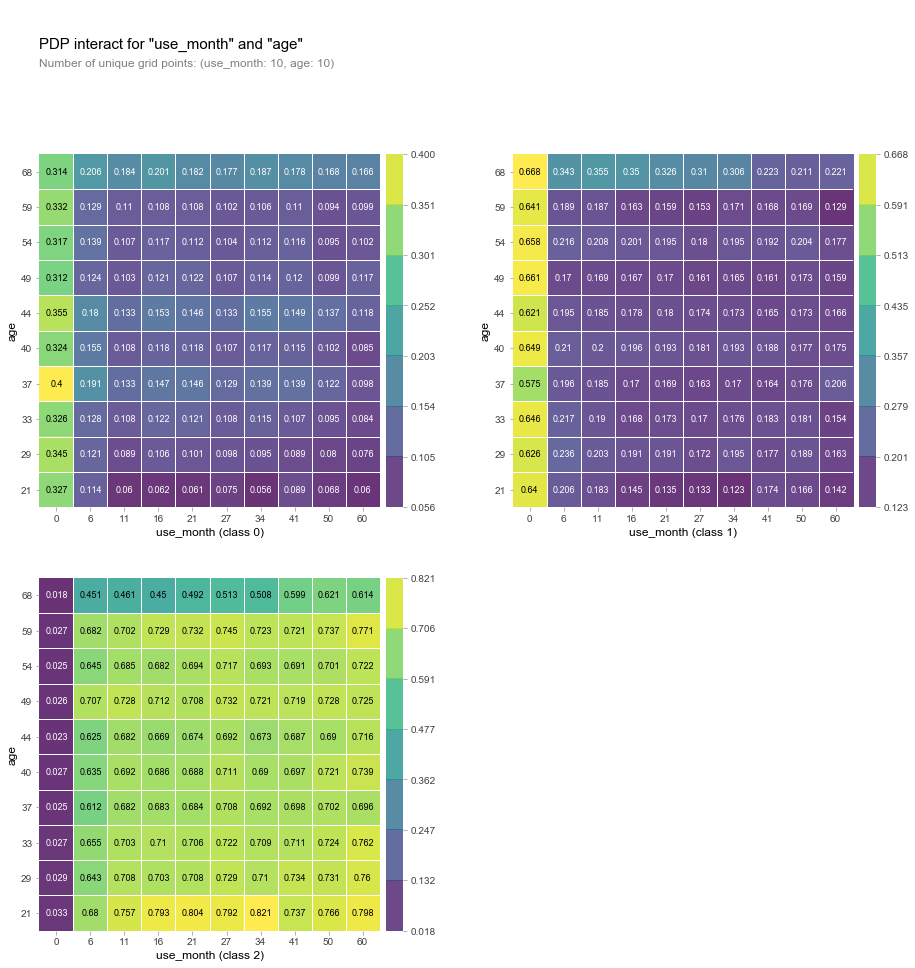

In [59]:
from pdpbox.pdp import pdp_isolate, pdp_plot,pdp_interact, pdp_interact_plot
feature = ['use_month', 'age']
isolated = pdp_interact(
    model=xgb_tuned, 
    dataset=X_train, 
    model_features=X_train.columns, 
    features=feature,
)
pdp_interact_plot(isolated, plot_type='grid', feature_names=feature);

In [63]:
import shap

explainer = shap.TreeExplainer(xgb_tuned.named_steps['classifier'])
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:income_type, edu_type, family_type, house_type, occyp_type

In [65]:
X_train[X_train['occyp_type'] == 'Unoccupied']

gender  car  reality income_type                       edu_type  \
index                                                                    
14          0    0        1   Pensioner  Secondary / secondary special   
18          0    0        1   Pensioner  Secondary / secondary special   
21          0    0        0   Pensioner  Secondary / secondary special   
24          0    0        0   Pensioner  Secondary / secondary special   
46          0    0        0   Pensioner  Secondary / secondary special   
...       ...  ...      ...         ...                            ...   
26431       0    0        1   Pensioner  Secondary / secondary special   
26432       0    1        1   Pensioner  Secondary / secondary special   
26439       0    0        1   Pensioner  Secondary / secondary special   
26441       0    0        1   Pensioner              Incomplete higher   
26443       0    0        1   Pensioner  Secondary / secondary special   

                family_type         house_type  occyp_type  family_size  age  \
index                                                                          
14     Single / not married  House / apartment  Unoccupied            1   62   
18                  Married  House / apartment  Unoccupied            2   63   
21                  Married  House / apartment  Unoccupied            2   58   
24     Single / not married  House / apartment  Unoccupied            1   61   
46                    Widow  House / apartment  Unoccupied            1   57   
...                     ...                ...         ...          ...  ...   
26431                 Widow  House / apartment  Unoccupied            1   57   
26432               Married  House / apartment  Unoccupied            2   61   
26439               Married  House / apartment  Unoccupied            2   52   
26441             Separated  House / apartment  Unoccupied            1   66   
26443  Single / not married  House / apartment  Unoccupied            1   61   

       work_year  use_month  income_total  
index                                      
14             0         41      157500.0  
18             0         37      216000.0  
21             0          7      157500.0  
24             0          5      202500.0  
46             0         24      135000.0  
...          ...        ...           ...  
26431          0         60      225000.0  
26432          0         17       72000.0  
26439          0         57       67500.0  
26441          0         43       90000.0  
26443          0         21       90000.0  

[4438 rows x 13 columns]

In [64]:
shap_values = xgb_tuned.named_steps['classifier'].get_feature_importance(Pool(X_train, y_train), type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

AttributeError: 'XGBClassifier' object has no attribute 'get_feature_importance'

In [ ]:
shap.summary_plot(shap_values, X)


## Submission

In [14]:
def submit(pipe, num):
    y_test_proba = pipe.predict_proba(X_test)
    submission.iloc[:, 1:] = y_test_proba
    submission.to_csv('data/submission' + str(num) + '.csv', index = False)

In [15]:
submit(xgb_tuned, 3)